In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import pyam
import pandas as pd
import sys
sys.path.append('/Users/stuartjenkins/Documents/$$Work/2019:02:01 - Carbon budgets with CO2-fe paper')
from fair_scm import *


# from scipy.stats import lognorm
# from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.ndimage.filters import gaussian_filter

from scipy.optimize import curve_fit

<IPython.core.display.Javascript object>

In [2]:
# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
co2_ems_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx', encoding='utf-8')
co2_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx', encoding='utf-8')
total_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_lower_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx', encoding='utf-8')
two_lower_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx', encoding='utf-8')
two_lower_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_higher_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx', encoding='utf-8')
two_higher_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx', encoding='utf-8')
two_higher_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx', encoding='utf-8')

# import RCP85 scenario to stitch onto past
RCP85_E = pd.read_csv('../RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_RF = pd.read_csv('../RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP3_E = pd.read_csv('../RCP_data/RCP3PD_EMISSIONS.csv',skiprows=36,index_col=0)
RCP3_RF = pd.read_csv('../RCP_data/RCP3PD_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP45_E = pd.read_csv('../RCP_data/RCP45_EMISSIONS.csv',skiprows=36,index_col=0)
RCP45_RF = pd.read_csv('../RCP_data/RCP45_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP6_E = pd.read_csv('../RCP_data/RCP6_EMISSIONS.csv',skiprows=36,index_col=0)
RCP6_RF = pd.read_csv('../RCP_data/RCP6_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx`


In [3]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2018
non_co2_forcing_average_over = 10

fbar_s = np.array([])
f0_s = np.array([])
f1_s = np.array([])
delta_fs = np.array([])

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.6
ECS_val = 2.75
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])
gamma = (1 - np.exp(-epsilon*H))/(epsilon*H)

# magicc like AGWP value
r0 = 32.4 # 33.6
rC = 0.019 # 0.0206
rT = 4.165 # 4.635

base_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems[year_val-1765] += 1. * 12 / 44

other_rf = RCP3_RF.TOTAL_ANTHRO_RF.values - RCP3_RF.CO2_RF.values

C_pulse, T_pulse = fair_scm(emissions=pulse_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)
C_base, T_base = fair_scm(emissions=base_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)

RF_net = (F_2x * np.log(C_pulse / C_0) / np.log(2.0)) - (F_2x * np.log(C_base / C_0) / np.log(2.0))
AGWP_CO2 = sp.integrate.simps(RF_net[year_val-1765:year_val+101-1765])
TCRE = (((H / AGWP_CO2) * (F_2x / TCR_val)) * (12 / 44000))**-1
print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')
print(H/AGWP_CO2)

TCR:  1.6 K
ECS:  2.75 K
calculated TCRE:  1.324006450562502 K/TtC
1184.7581636131479


the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


(-0.1, 1.0)

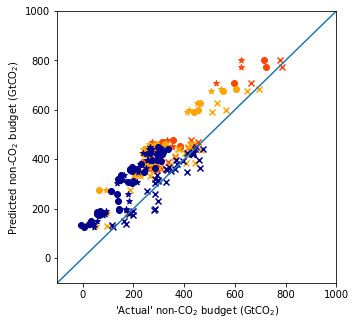

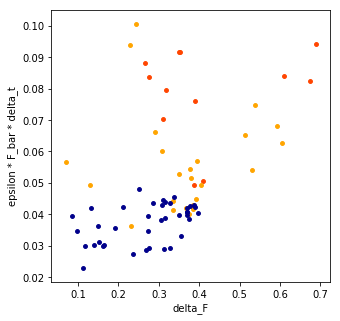

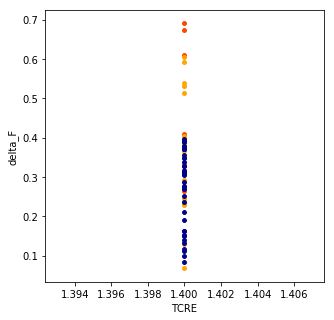

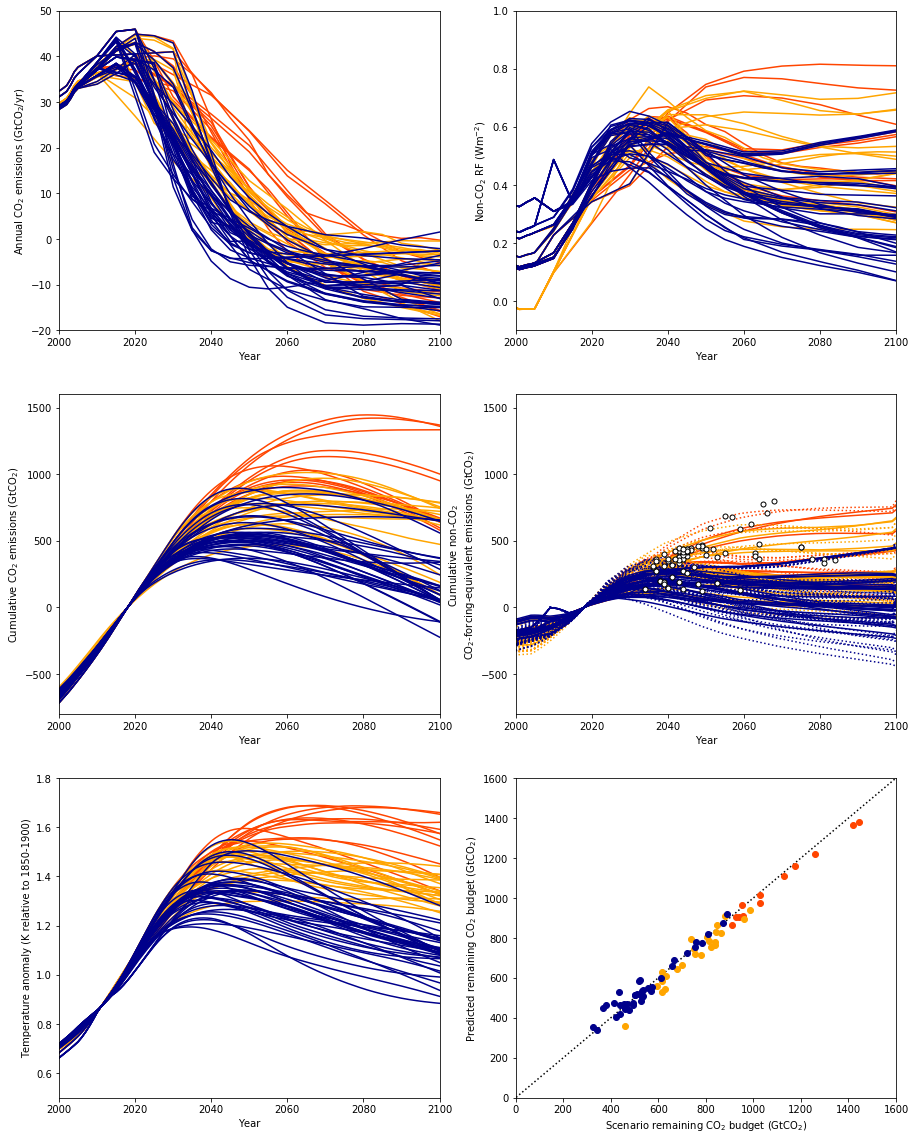

In [4]:
k = 0

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$)')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(3,2,figsize=(15,20))
ax[0,0].set_xlim(2000,2100)
ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[2,0].set_xlim(2000,2100)
ax[2,1].set_xlim(0,1600)
ax[2,1].set_ylim(0,1600)
ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Cumulative CO$_2$ emissions (GtCO$_2$)')
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Cumulative non-CO$_2$ \nCO$_2$-forcing-equivalent emissions (GtCO$_2$)')
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Temperature anomaly (K relative to 1850-1900)')
ax[2,1].set_xlabel('Scenario remaining CO$_2$ budget (GtCO$_2$)')
ax[2,1].set_ylabel('Predicted remaining CO$_2$ budget (GtCO$_2$)')

TCRE = 1.4
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val



for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='orangered')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')

                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='orange')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   

                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
    for i in range(0,len(list(co2_ems_df.models()))):
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
            k += 1
            print(k)
            
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax[2,0].plot(single_ems.index, T_run - T_run[2011-1765] + 0.87, color='darkblue')
                ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)
                delta_fs = np.append(delta_fs, F_1 - F_0)

# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax[2,0].set_ylim(0.5,1.8)
ax[1,1].set_ylim(-800,1600)
ax[1,0].set_ylim(-800,1600)
ax[0,0].set_ylim(-20,50)
ax[0,1].set_ylim(-0.1,1.0)






invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


i, j:  0 ,  0
CO2:  158.55329200000156
non-CO2:  -70.4639674628413
i, j:  1 ,  0
CO2:  245.9010397799992
non-CO2:  -24.244127905404824
i, j:  1 ,  1
CO2:  320.864068720001
non-CO2:  -52.66409582617219
i, j:  3 ,  0
CO2:  124.01753099300049
non-CO2:  207.95442859502324
i, j:  3 ,  1
CO2:  164.38112388500005
non-CO2:  84.65976681235855
i, j:  3 ,  2
CO2:  20.30187977000071
non-CO2:  205.6124500988283
i, j:  3 ,  3
CO2:  45.692387610500155
non-CO2:  213.5101420362199
i, j:  3 ,  4
CO2:  163.83923153399988
non-CO2:  16.620985523264576
i, j:  3 ,  5
CO2:  373.1061351357503
non-CO2:  -72.89508622004107
i, j:  3 ,  6
CO2:  98.39163806099911
non-CO2:  143.79642957014426
i, j:  3 ,  7
CO2:  38.42583983225105
non-CO2:  163.9237399602096
i, j:  3 ,  8
CO2:  340.1492781790001
non-CO2:  -153.26887456159318
i, j:  4 ,  0
CO2:  128.47178331999933
non-CO2:  155.01940874763213
i, j:  4 ,  1
CO2:  560.1123525090021
non-CO2:  170.24187654781414
i, j:  5 ,  0
CO2:  -108.34282259499825
non-CO2:  451.420196

[Text(0, 0, '-1.31'),
 Text(0, 0, '-0.65'),
 Text(0, 0, '0.0'),
 Text(0, 0, '0.65'),
 Text(0, 0, '1.31'),
 Text(0, 0, '1.96')]

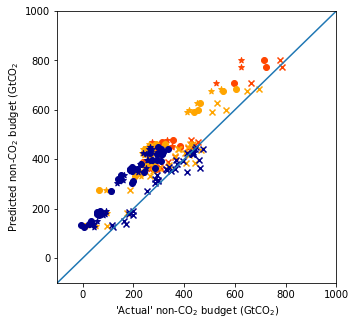

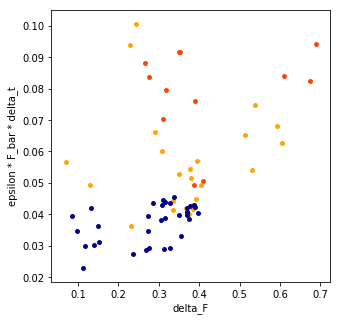

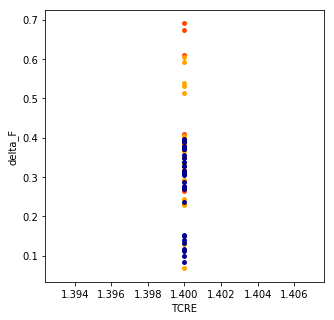

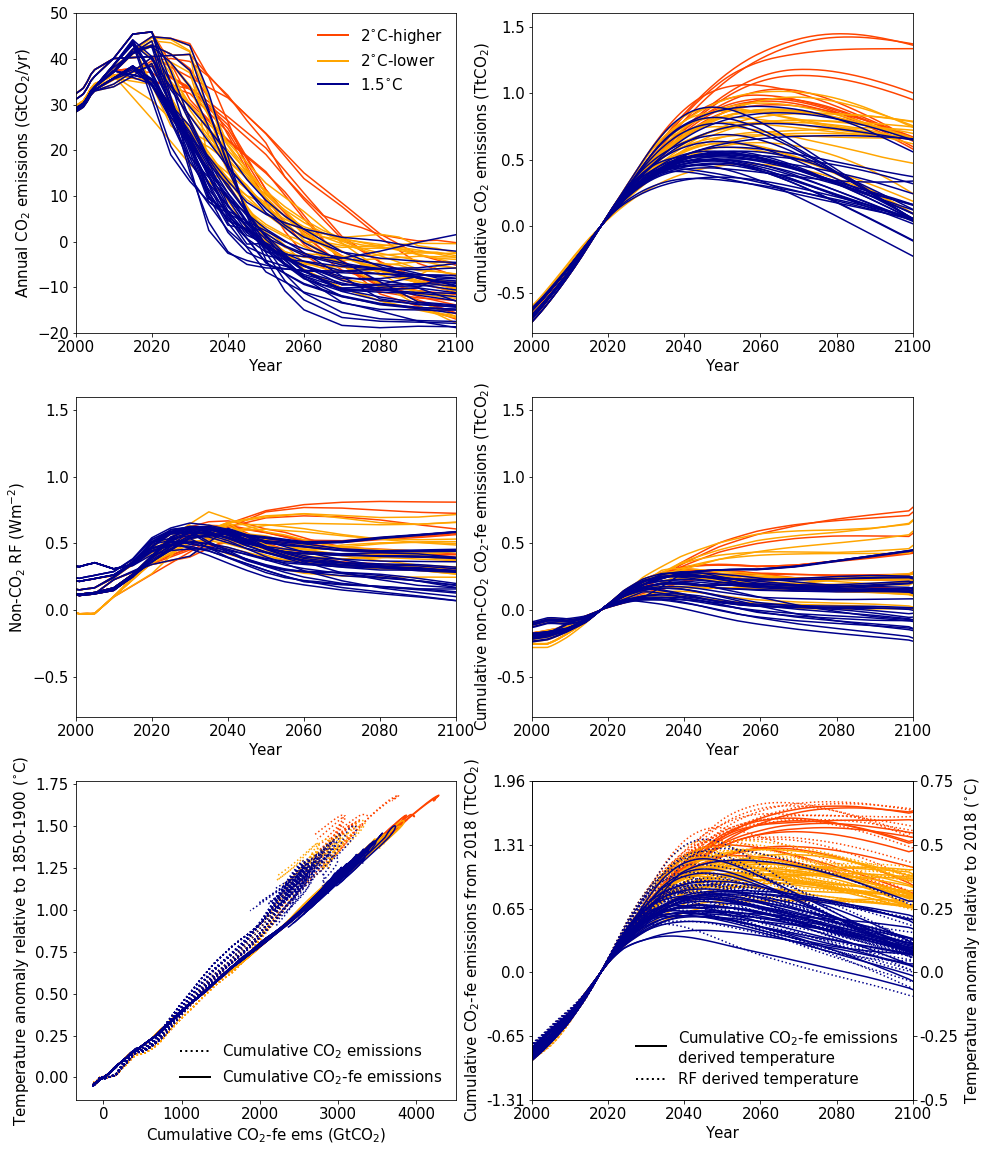

In [5]:
all_CO2_ems = {}
all_nonCO2_RF = {}
all_total_RF = {}

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(3,2,figsize=(15,20))
ax[0,0].set_xlim(2000,2100)
ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[2,1].set_xlim(2000,2100)
# ax[2,1].set_xlim(0,1600)
# ax[2,1].set_ylim(0,1600)
# ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ftsize = 15

ax[0,0].set_xlabel('Year', fontsize=ftsize)
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)', fontsize=ftsize)
ax[1,0].set_xlabel('Year', fontsize=ftsize)
ax[1,0].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)', fontsize=ftsize)
ax[0,1].set_xlabel('Year', fontsize=ftsize)
ax[0,1].set_ylabel('Cumulative CO$_2$ emissions (TtCO$_2$)', fontsize=ftsize)
ax[0,1].set_yticklabels([-1.0,-0.5,0.0,0.5,1.0,1.5])
ax[1,1].set_xlabel('Year', fontsize=ftsize)
ax[1,1].set_ylabel('Cumulative non-CO$_2$ CO$_2$-fe emissions (TtCO$_2$)', fontsize=ftsize)
ax[1,1].set_yticklabels([-1.0,-0.5,0.0,0.5,1.0,1.5])
ax[2,1].set_xlabel('Year', fontsize=ftsize)
ax[2,1].set_ylabel('Cumulative CO$_2$-fe emissions from 2018 (TtCO$_2$)', fontsize=ftsize)
ax[2,0].set_xlabel('Cumulative CO$_2$-fe ems (GtCO$_2$)', fontsize=ftsize)
ax[2,0].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=ftsize)

# ax[0,0].set_yticks([-20,-10,0,10,20,30,40,50,60])

ax[0,0].tick_params(labelsize=ftsize)
ax[0,1].tick_params(labelsize=ftsize)
ax[2,1].tick_params(labelsize=ftsize)
ax[1,0].tick_params(labelsize=ftsize)
ax[1,1].tick_params(labelsize=ftsize)
ax[2,0].tick_params(labelsize=ftsize)

TCRE = 1.4
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val


for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        all_CO2_ems[list(two_higher_co2_ems_df.models())[i]] = {}
        all_nonCO2_RF[list(two_higher_co2_ems_df.models())[i]] = {}
        all_total_RF[list(two_higher_co2_ems_df.models())[i]] = {}
        
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax[1,0].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax[0,1].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax[2,1].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orangered', linestyle=':')
                ax[2,1].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orangered', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')
                ax[2,0].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered')
                ax[2,0].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)
                
                all_CO2_ems[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        if list(two_lower_co2_ems_df.models())[i] not in list(two_higher_co2_ems_df.models()):
            all_CO2_ems[list(two_lower_co2_ems_df.models())[i]] = {}
            all_nonCO2_RF[list(two_lower_co2_ems_df.models())[i]] = {}
            all_total_RF[list(two_lower_co2_ems_df.models())[i]] = {}
        
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax[1,0].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax[0,1].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax[2,1].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orange', linestyle=':')
                ax[2,1].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orange', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   
                ax[2,0].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange')
                ax[2,0].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
                all_CO2_ems[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values
        
#     for i in range(0,len(list(co2_ems_df.models()))):
    for i in [0,1,3,4,5,6,7]:
        if list(co2_ems_df.models())[i] not in list(two_higher_co2_ems_df.models()):
            if list(co2_ems_df.models())[i] not in list(two_lower_co2_ems_df.models()):
                all_CO2_ems[list(co2_ems_df.models())[i]] = {}
                all_nonCO2_RF[list(co2_ems_df.models())[i]] = {}
                all_total_RF[list(co2_ems_df.models())[i]] = {}
            
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
            print('i, j: ', i, ', ', j)
            
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                
#                 print(single_nonco2rf.values)
                
                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax[1,0].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax[0,1].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax[2,1].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='darkblue', linestyle=':')
                ax[2,1].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='darkblue', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')
                ax[2,0].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue')
                ax[2,0].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue',linestyle=':')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                #ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                #ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)

                delta_fs = np.append(delta_fs, F_1 - F_0)
    
                all_CO2_ems[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values
        
                print('CO2: ', (np.cumsum(single_ems.values)[2100-1765] - np.cumsum(single_ems.values)[2018-1765])*44/12)
                print('non-CO2: ', (np.cumsum(E_nonco2_back)[2100-1765] - np.cumsum(E_nonco2_back)[2018-1765])*44/12)
#                 print((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])[year_temp_max-1765])
#                 print((np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])[year_temp_max-1765])
# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax[1,1].set_ylim(-800,1600)
ax[0,1].set_ylim(-800,1600)
ax[0,0].set_ylim(-20,50)
ax[1,0].set_ylim(-0.8,1.6)

legend_elements = [Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions \nderived temperature'),
                   Line2D([0], [0], color='black', lw=2, linestyle=':', label='RF derived temperature')]
ax[2,1].legend(handles=legend_elements, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

legend_elements2 = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$ emissions'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions')]
ax[2,0].legend(handles=legend_elements2, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

legend_elements3 = [Line2D([0], [0], color='orangered', lw=2, linestyle='-', label='2$^{\circ}$C-higher'),
                   Line2D([0], [0], color='orange', lw=2, linestyle='-', label='2$^{\circ}$C-lower'),
                   Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='1.5$^{\circ}$C')]
ax[0,0].legend(handles=legend_elements3, loc='upper right', framealpha=1.0, edgecolor='white', fontsize=ftsize)

ax[0,0].grid(False)

ax[2,1].set_ylim(0.54,1.79)
ax_temp = ax[2,1].twinx()
ax_temp.set_ylim(0.54,1.79)
ax_temp.set_yticks([0.54,0.79,1.04,1.29,1.54,1.79])
ax_temp.set_yticklabels([-0.5,-0.25,0.0,0.25,0.5,0.75])
ax_temp.set_ylabel('Temperature anomaly relative to 2018 ($^{\circ}$C)', fontsize=ftsize)
ax_temp.tick_params(labelsize=ftsize)

ax[2,1].set_yticks([-0.5+1.04,-0.25+1.04,1.04,0.25+1.04,0.5+1.04,0.75+1.04])
ax[2,1].set_yticklabels([np.round((-0.5/TCRE)*44/12,2),np.round((-0.25/1.4)*44/12,2),0.0,np.round((0.25/1.4)*44/12,2),np.round((0.5/1.4)*44/12,2),np.round((0.75/1.4)*44/12,2)])

# fig.savefig('Figure1.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


110.63349766318778
135.9826915954213
142.09088820773027
214.45422692404816
180.00328419404198
171.7311306665445
181.37800957085747
170.2707441089303
225.54327050858151
164.21528374524337
192.30453836525558
205.96250007937533
151.88043230124333
192.00650308646792
190.64130797254518
196.07269015218722
158.00445450315792
252.66402059397248
268.3058331681884
294.0491018031127
297.57472662726053
293.67586990353425
292.0215241536964
257.4953905664386
263.46829047503246
251.2108428154056
275.17529136176756
237.78603293570208
249.76439594913322
260.53325001898844
220.01651896380113
90.7047481090613
43.910504860097355
77.98898670773958
57.56081171849826
80.20579989303029
33.014747964157486
44.32278540660553
86.47883862496805


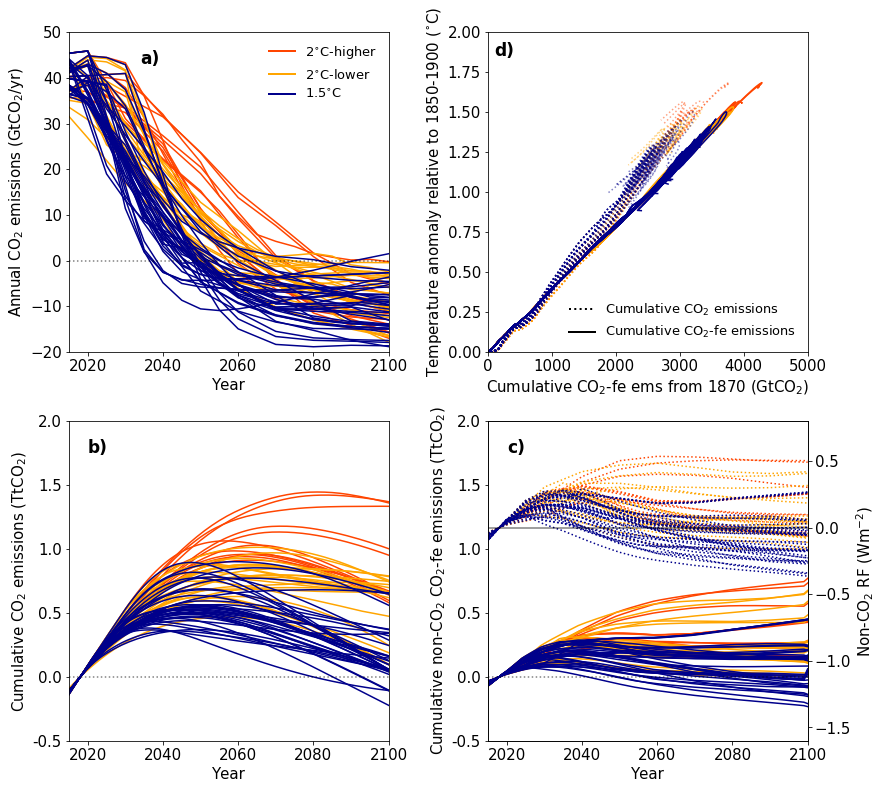

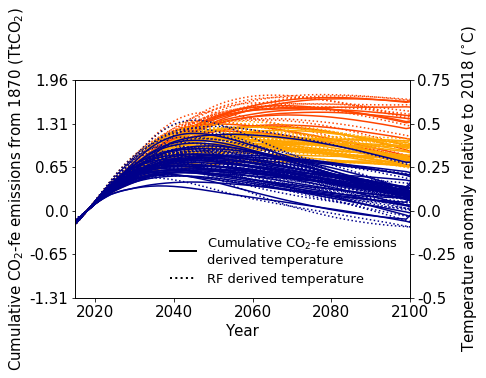

In [18]:
TCR_val = 1.6
ECS_val = 2.75

all_CO2_ems = {}
all_nonCO2_RF = {}
all_total_RF = {}

# fig1, ax1 = plt.subplots(figsize=(5,5))
# ax1.plot([-100,1000],[-100,1000])
# ax1.set_xlim(-100,1000)
# ax1.set_ylim(-100,1000)
# ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
# ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$')

# fig2, ax2 = plt.subplots(figsize=(5,5))
# ax2.set_xlabel('delta_F')
# ax2.set_ylabel('epsilon * F_bar * delta_t')

# fig3, ax3 = plt.subplots(figsize=(5,5))
# ax3.set_xlabel('TCRE')
# ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(2,2,figsize=(12,12))
ax[0,0].set_position([0.115,0.55,0.37,0.37])
ax[1,0].set_position([0.115,0.1,0.37,0.37])
ax[0,1].set_position([0.6,0.55,0.37,0.37])
ax[1,1].set_position([0.6,0.1,0.37,0.37])
fig2, ax2 = plt.subplots()

ax[0,0].set_xlim(2015,2100)
# ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2015,2100)
ax[1,1].set_xlim(2015,2100)
ax2.set_xlim(2015,2100)
# ax[2,1].set_xlim(0,1600)
# ax[2,1].set_ylim(0,1600)
# ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ftsize = 15

ax[0,0].set_xlabel('Year', fontsize=ftsize)
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)', fontsize=ftsize)
ax[1,0].set_xlabel('Year', fontsize=ftsize)
ax[1,0].set_ylabel('Cumulative CO$_2$ emissions (TtCO$_2$)', fontsize=ftsize)
ax[1,1].set_xlabel('Year', fontsize=ftsize)
ax[1,1].set_ylabel('Cumulative non-CO$_2$ CO$_2$-fe emissions (TtCO$_2$)', fontsize=ftsize)
ax2.set_xlabel('Year', fontsize=ftsize)
ax2.set_ylabel('Cumulative CO$_2$-fe emissions from 1870 (TtCO$_2$)', fontsize=ftsize)
# ax[2,0].set_xlabel('Cumulative CO$_2$-fe ems (GtCO$_2$)', fontsize=ftsize)
# ax[2,0].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=ftsize)
ax[0,1].set_xlabel('Cumulative CO$_2$-fe ems from 1870 (GtCO$_2$)', fontsize=ftsize)
ax[0,1].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=ftsize)


# ax[0,0].set_yticks([-20,-10,0,10,20,30,40,50,60])

ax[0,0].tick_params(labelsize=ftsize)
ax[1,0].tick_params(labelsize=ftsize)
ax2.tick_params(labelsize=ftsize)
ax[0,1].tick_params(labelsize=ftsize)
ax[1,1].tick_params(labelsize=ftsize)
# ax[2,0].tick_params(labelsize=ftsize)

ax_11_nonco2_rf = ax[1,1].twinx()
ax_11_nonco2_rf.set_ylim(-1.6,0.8)
ax_11_nonco2_rf.tick_params(labelsize=ftsize)
ax_11_nonco2_rf.set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)', fontsize=ftsize)
ax_11_nonco2_rf.set_position([0.6,0.1,0.37,0.37])

TCRE = 1.4
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val


for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        all_CO2_ems[list(two_higher_co2_ems_df.models())[i]] = {}
        all_nonCO2_RF[list(two_higher_co2_ems_df.models())[i]] = {}
        all_total_RF[list(two_higher_co2_ems_df.models())[i]] = {}
        
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
#                 ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax_11_nonco2_rf.plot(single_nonco2rf.index, single_nonco2rf.values - single_nonco2rf.values[2018-1765], color='orangered', linestyle=':')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax2.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orangered', linestyle=':')
                ax2.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orangered', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')
#                 ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered')
#                 ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered',linestyle=':')
                
                ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='orangered')
                ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='orangered',linestyle=':', alpha=0.5)


#                 ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
#                 ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

#                 ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
#                 ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
#                 ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)
                
                all_CO2_ems[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(two_higher_co2_ems_df.models())[i]][list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        if list(two_lower_co2_ems_df.models())[i] not in list(two_higher_co2_ems_df.models()):
            all_CO2_ems[list(two_lower_co2_ems_df.models())[i]] = {}
            all_nonCO2_RF[list(two_lower_co2_ems_df.models())[i]] = {}
            all_total_RF[list(two_lower_co2_ems_df.models())[i]] = {}
        
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
#                 ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax_11_nonco2_rf.plot(single_nonco2rf.index, single_nonco2rf.values - single_nonco2rf.values[2018-1765], color='orange', linestyle=':')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax2.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orange', linestyle=':')
                ax2.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orange', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   
#                 ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange')
#                 ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange',linestyle=':')
        
                ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='orange')
                ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='orange',linestyle=':', alpha=0.5)


#                 ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
#                 ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

#                 ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
#                 ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
#                 ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
                all_CO2_ems[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(two_lower_co2_ems_df.models())[i]][list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values
        
#     for i in range(0,len(list(co2_ems_df.models()))):
    for i in [0,1,2,3,4,5,6,7]:
        if list(co2_ems_df.models())[i] not in list(two_higher_co2_ems_df.models()):
            if list(co2_ems_df.models())[i] not in list(two_lower_co2_ems_df.models()):
                all_CO2_ems[list(co2_ems_df.models())[i]] = {}
                all_nonCO2_RF[list(co2_ems_df.models())[i]] = {}
                all_total_RF[list(co2_ems_df.models())[i]] = {}
            
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
#             print('i, j: ', i, ', ', j)
#             print(list(co2_ems_df.models())[i], list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j])
            
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                
#                 print(single_nonco2rf.values)
                
                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
#                 ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax_11_nonco2_rf.plot(single_nonco2rf.index, single_nonco2rf.values - single_nonco2rf.values[2018-1765], color='darkblue', linestyle=':')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax2.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='darkblue', linestyle=':')
                ax2.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='darkblue', linestyle='-')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')
#                 ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue')
#                 ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue',linestyle=':')

                ax[0,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='darkblue')
                ax[0,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1850-1765:1901-1765]), color='darkblue',linestyle=':', alpha=0.5)


#                 ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
#                 ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
#                 ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
#                 ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                #ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
#                 ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                #ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)

                delta_fs = np.append(delta_fs, F_1 - F_0)
    
                all_CO2_ems[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_ems.values*44/12
                all_nonCO2_RF[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_nonco2rf.values
                all_total_RF[list(co2_ems_df.models())[i]][list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]] = single_totalrf.values
        
# un-comment just these ones!!
#                 print('CO2: ', (np.cumsum(single_ems.values)[2100-1765] - np.cumsum(single_ems.values)[2018-1765])*44/12)
#                 print('Non-CO2: ', (np.cumsum(E_nonco2_back)[2100-1765] - np.cumsum(E_nonco2_back)[2018-1765])*44/12)
        
#                 print('CO2: ', (np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765])*44/12)
                print((np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765])*44/12)

#                 print((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])[year_temp_max-1765])
#                 print((np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])[year_temp_max-1765])
# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax[1,1].set_ylim(-500,2000)
ax[1,0].set_ylim(-500,2000)
ax[0,1].set_ylim(0,2)
ax[0,1].set_xlim(0,5000)
ax[1,1].set_yticklabels([-0.5,0.0,0.5,1.0,1.5,2.0])
ax[1,0].set_yticklabels([-0.5,0.0,0.5,1.0,1.5,2.0])
ax[0,0].set_ylim(-20,50)
# ax[0,1].set_ylim(-0.8,1.6)

legend_elements = [Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions \nderived temperature'),
                   Line2D([0], [0], color='black', lw=2, linestyle=':', label='RF derived temperature')]
ax2.legend(handles=legend_elements, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=13)

legend_elements2 = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$ emissions'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions')]
ax[0,1].legend(handles=legend_elements2, loc='lower right', framealpha=1.0, edgecolor='white', fontsize=13)

legend_elements3 = [Line2D([0], [0], color='orangered', lw=2, linestyle='-', label='2$^{\circ}$C-higher'),
                   Line2D([0], [0], color='orange', lw=2, linestyle='-', label='2$^{\circ}$C-lower'),
                   Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='1.5$^{\circ}$C')]
ax[0,0].legend(handles=legend_elements3, loc='upper right', framealpha=1.0, edgecolor='white', fontsize=13)

ax[0,0].grid(False)

ax2.set_ylim(0.54,1.79)
ax_temp = ax2.twinx()
ax_temp.set_ylim(0.54,1.79)
ax_temp.set_yticks([0.54,0.79,1.04,1.29,1.54,1.79])
ax_temp.set_yticklabels([-0.5,-0.25,0.0,0.25,0.5,0.75])
ax_temp.set_ylabel('Temperature anomaly relative to 2018 ($^{\circ}$C)', fontsize=ftsize)
ax_temp.tick_params(labelsize=ftsize)

ax2.set_yticks([-0.5+1.04,-0.25+1.04,1.04,0.25+1.04,0.5+1.04,0.75+1.04])
ax2.set_yticklabels([np.round((-0.5/TCRE)*44/12,2),np.round((-0.25/1.4)*44/12,2),0.0,np.round((0.25/1.4)*44/12,2),np.round((0.5/1.4)*44/12,2),np.round((0.75/1.4)*44/12,2)])

ax[0,0].text(2034,43,'a)',fontsize=17, fontweight='bold')
ax[1,0].text(2020,1750,'b)',fontsize=17, fontweight='bold')
ax[1,1].text(2020,1750,'c)',fontsize=17, fontweight='bold')
ax[0,1].text(100,1.85,'d)',fontsize=17, fontweight='bold')

ax[0,0].axhline(y=0, linestyle=':', alpha=0.5, color='black')
ax[1,0].axhline(y=0, linestyle=':', alpha=0.5, color='black')
ax_11_nonco2_rf.axhline(y=0, linestyle='-', alpha=0.5, color='black')
ax[1,1].axhline(y=0, linestyle=':', alpha=0.5, color='black')

# fig.savefig('Figure1_new.pdf', dpi=500, bbox_inches="tight") 

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


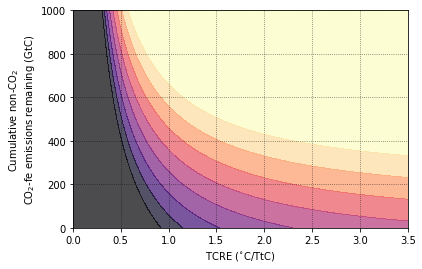

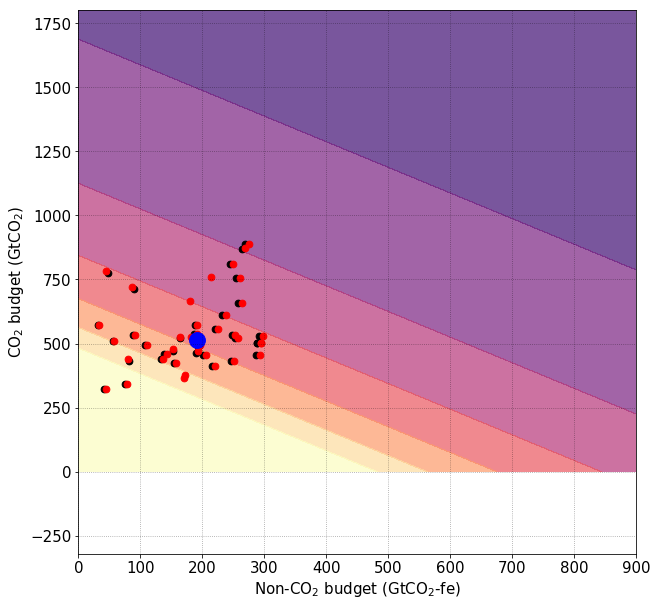

In [63]:

# 2100 budgets
# co2_ems = np.array([158.55329200000156,245.9010397799992,320.864068720001,288.02658000000037,368.87109499999906,-106.93259999999923,345.97837499999986,147.3739500000013,124.01753099300049,164.38112388500005,20.30187977000071,45.692387610500155,163.83923153399988,373.1061351357503,98.39163806099911,38.42583983225105,340.1492781790001,128.47178331999933,560.1123525090021,-108.34282259499825,94.78099092000063,-103.48349974899902,-222.56607314700034,46.76581051999957,49.6617530199998,47.14378352000116,54.637986379999724,61.27094860000125,56.041420980000794,57.25166604000098,56.61461377999785,50.89488120000161,57.972396209999864,60.436925949997395,52.88599839000062,52.54674336999866,657.5694673299981,648.5614586400002,648.4365049599993])
# non_co2_ems = np.array([-70.4639674628413,-24.244127905404824,-52.66409582617219,63.27815659669775,52.00606006339118,39.926194031614216,47.0505236794098,41.34418661942995,207.95442859502324,84.65976681235855,205.6124500988283,213.5101420362199,16.620985523264576,-72.89508622004107,143.79642957014426,163.9237399602096,-153.26887456159318,155.01940874763213,170.24187654781414,451.42019665192447,445.22823869993744,451.40654184322443,449.9047141400759,235.84219635210016,247.56609787671547,243.86511804446832,160.75171472944723,143.54665350105628,129.7492539509943,129.52209627342003,125.9369247104125,14.736931683335177,-232.62240611889,-1.0003237140534462,-141.3120114844961,-85.14172697570767,-209.0828561729954,-136.5609154940864,-73.14168624144436])

# peak warming budgets
co2_ems = np.array([493.4247521400004,439.52252854000045,458.2368239799991,758.7910960000012,666.2578900000004,379.1918719999997,524.951343799999,366.4252079999999,557.1725910887994,526.3878807279995,469.27926084000046,455.77961621199967,476.8944117598001,571.5305824220007,536.5467654884004,492.77572350040003,422.5479301320001,531.8926294469995,873.3185199984999,502.0185970995012,530.2877065285003,501.0622202040011,456.728585144501,520.1686380199999,658.8707508199991,433.71306662000006,889.1907381799996,611.9449258400001,809.6617924799998,754.717035340001,412.14293739999965,535.16337082,324.5916408599995,342.3244957999996,508.76475554000007,438.168848519999,573.45750378,783.1496056400005,720.7839515999999])
non_co2_ems = np.array([110.63349766318778,135.9826915954213,142.09088820773027,214.45422692404816,180.00328419404198,171.7311306665445,181.37800957085747,170.2707441089303,225.54327050858151,164.21528374524337,192.30453836525558,205.96250007937533,151.88043230124333,192.00650308646792,190.64130797254518,196.07269015218722,158.00445450315792,252.66402059397248,268.3058331681884,294.0491018031127,297.57472662726053,293.67586990353425,292.0215241536964,257.4953905664386,263.46829047503246,251.2108428154056,275.17529136176756,237.78603293570208,249.76439594913322,260.53325001898844,220.01651896380113,90.7047481090613,43.910504860097355,77.98898670773958,57.56081171849826,80.20579989303029,33.014747964157486,44.32278540660553,86.47883862496805])

# attempt at new figure 4
n = 100

TCRE_values = np.random.lognormal(0.348, 0.289, n)

total_ems_remaining = (1.5-1.04)*1000/TCRE_values
nonCO2_co2fe_ems = np.arange(0,1000,100)

TCREs, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,3.5,100), np.linspace(0,1000,100))

CO2_budgets = (1.5-1.04)*1000/TCREs - nonCO2_co2fe_budgets

plt.contourf(TCREs, nonCO2_co2fe_budgets, CO2_budgets, [-200,-100,0,100,200,300,400,500], extend='both', cmap=plt.cm.magma.reversed(), alpha=0.7, linewidths=0.0)
plt.grid(True, linestyle=':', color='black', alpha = 0.6)
plt.xlabel('TCRE ($^{\circ}$C/TtC)')
plt.ylabel('Cumulative non-CO$_2$ \nCO$_2$-fe emissions remaining (GtC)')

CO2_peak = np.array([493.42,439.52,458.24,557.17,519.96,464.71,455.78,469.96,571.53,536.55,488.15,422.55,531.89,866.98,502.02,530.29,501.06,456.73,520.17,658.87,433.71,889.19,611.94,809.66,754.72,412.14,535.16,324.59,342.32,508.76,430.83,573.46,773.19,711.89])
non_CO2_peak = np.array([107.49,132.40,138.38,220.41,163.26,189.73,201.16,151.70,187.23,185.94,193.30,154.05,247.42,264.57,288.28,291.68,287.91,286.32,251.98,257.46,246.03,268.86,232.28,243.94,254.51,215.30,87.80,41.95,75.41,55.33,81.22,30.99,48.27,88.85])

scen_nonCO2_budgets = non_CO2_peak
scen_total_budgets = CO2_peak + non_CO2_peak
scen_co2_budgets = CO2_peak

CO2_budgets, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,1000,100), np.linspace(0.001,1000,100))
TCREs = (1.5-1.04)*1000/(CO2_budgets + nonCO2_co2fe_budgets)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(scen_nonCO2_budgets, scen_co2_budgets, color='black', s=45)

plt.scatter(non_co2_ems, co2_ems, color='red', s=45)

plt.scatter(np.median(scen_nonCO2_budgets), np.median(scen_co2_budgets), color='blue', s=250)
plt.contourf(nonCO2_co2fe_budgets*44/12, CO2_budgets*44/12, TCREs, [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5], cmap=plt.cm.magma, alpha=0.7, linewidths=0.0, zorder=-100, extend='both')
plt.xlim(0,900)
plt.ylim(-320,1800)
plt.grid(True, color='black', linestyle=':', alpha=0.4)

# plt.annotate('0.5$^{\circ}$C/TtC',xy=(335*44/12,130*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('1.0$^{\circ}$C/TtC',xy=(185*44/12,120*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('1.5$^{\circ}$C/TtC',xy=(120*44/12,110*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('2.0$^{\circ}$C/TtC',xy=(83*44/12,102*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('2.5$^{\circ}$C/TtC',xy=(58*44/12,95*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('3.0$^{\circ}$C/TtC',xy=(42*44/12,87*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')
# plt.annotate('3.5$^{\circ}$C/TtC',xy=(10*44/12,70*44/12),rotation=-66,color='black',fontsize=12, fontweight='bold')

# ax.plot([np.min(scen_co2_budgets), np.min(scen_co2_budgets)],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
# ax.plot([np.max(scen_co2_budgets), np.max(scen_co2_budgets)],[0,1000*44/12], linestyle='--', color='black', alpha=0.7)
# ax.plot([0,1000*44/12],[np.min(scen_nonCO2_budgets), np.min(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)
# ax.plot([0,1000*44/12],[np.max(scen_nonCO2_budgets), np.max(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)

# ax.plot([0,(155 + ((185-155)/5))*44/12],[(155 + ((185-155)*1/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

# ax.plot([0,(307 + ((460-307)*2/5))*44/12],[(307 + ((460-307)*2/5))*44/12,0], linestyle='-.', color='black', alpha=0.7)

# ax.set_xticklabels([0,100,200,300,400,500,600], fontsize=15)
# ax.set_yticklabels([0,20,40,60,80,100,120,140], fontsize=15)
ax.set_ylabel('CO$_2$ budget (GtCO$_2$)', fontsize=15)
ax.set_xlabel('Non-CO$_2$ budget (GtCO$_2$-fe)', fontsize=15)
ax.tick_params(labelsize=15)
plt.show()

# fig.savefig('Figure4_66percentile.pdf', dpi=300)

